# MC Simulations with both DC and NDC in a heterogeneous group


In [ ]:
# Libraries

!pip install fast-pagerank

from IPython import get_ipython
get_ipython().magic('reset -sf')
!pip install faiss-gpu
import faiss
import numpy as np
import torch
import random
import networkx as nx
import time
from scipy import sparse
from fast_pagerank import pagerank
from fast_pagerank import pagerank_power
device='cuda'
res = faiss.StandardGpuResources()

# Total number of agents
N = np.arange(200,1200,step=200)
s_pop = np.arange(0,1.1,step=0.1)
# Mean opinion value of the initial distribution
mu = 0.5*np.pi/180
# Variance of the initial opinion distribution
var = np.array([10,20])*np.pi/180
# Maximum in-degree of agents
max_degree = np.arange(0.25,1.25,step=0.25)
# Minimum in-degree of agents
min_degree = 0.05
# Confidence threshold
s_tol = 5*np.pi/180
f_tol = 30*np.pi/180
# Total simulation time
Final_Time = 500
# Monte Carlo Runs
Monte_Carlo = 100
Total_Size = len(N)*len(var)*len(max_degree)*len(s_pop)

start=time.time()
def generate_random_graph(c_t,min_d,max_d,Total_Agents, Mean, Variance,Identity_Matrix):
  ''' 
  
  Generate a connected network based on opinion similarity with no opinion leaders
  
  '''
  not_connected = True 
  leaders = True
  Separation = torch.zeros((Total_Agents,Total_Agents),dtype=torch.double,device='cuda')
  Neighbors = torch.zeros((Total_Agents,Total_Agents),device='cuda')

  Adjacency_Matrix = torch.zeros((Total_Agents,Total_Agents),dtype=torch.double,device='cuda')
  # Indices Padding
  Padding = torch.arange(0,Total_Agents,step=1,device='cuda')[:,None]*torch.ones((Total_Agents,max_d),
            dtype=torch.long,device='cuda')
  In_degree = torch.zeros((Total_Agents,),dtype=torch.long,device='cuda')
  while not_connected:
    leaders = True
    while leaders:
      Opinions = torch.normal(Mean,Variance,(Total_Agents,),device='cuda')
      Max_Degree = torch.randint(min_d,max_d,(Total_Agents,)).cuda()
      # Find neighbors upto max_degree
      # Pytorch to numpy
      Current = np.float32(Opinions.cpu().detach().numpy())
      index_flat = faiss.IndexFlatL2(Current[:,None].shape[1])
      gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)
      gpu_index_flat.add(Current[:,None])
      m, n = gpu_index_flat.search(Current[:,None], max_d)
      tensor_n = torch.from_numpy(n).long()
      # Indices of possible neighbors
      Neighbors[Padding, tensor_n] = 1
      # Value Separation 
      Separation[Padding, tensor_n] = torch.squeeze(torch.cdist(Opinions[:,None][:,None],Opinions[:,None][tensor_n],p=2)).double()
      Separation[Neighbors==0] = Total_Agents           
      Adjacency_Matrix[torch.logical_and(Separation<=c_t[:,None],Neighbors==1)] = 1
      Adjacency_Matrix -= Identity_Matrix
      Adjacency_Matrix[torch.where(torch.cumsum(Adjacency_Matrix,axis=1)>Max_Degree[:,None])]=0
      # Check for leaders
      In_Degree = torch.sum(Adjacency_Matrix,1)
      if torch.where(In_Degree==0)[0].size(0)==0:
        leaders = False
    # Check for connectedness
    G = nx.from_numpy_matrix(Adjacency_Matrix.cpu().detach().numpy(),create_using=nx.DiGraph)
    if nx.is_weakly_connected(G)==True:
      not_connected = False
  return Adjacency_Matrix+Identity_Matrix,In_Degree,Neighbors,Separation,Opinions, Max_Degree

def neighbors_and_weights(Total_Agents,Node_Weights,Adjacency_Matrix,Identity_Matrix,Separation,Tol):
  '''
  (a) Assign weights to the direct ties
  (b) Find 2/3 hop neighbors and weights
  (c) Comment 2/3-hop portions when not considered in simulations
  '''
  
  # Direct Ties: 1-Hop
  adj_matrix = Adjacency_Matrix-Identity_Matrix
  # 2-Hop
  two_hop_matrix = torch.zeros((Total_Agents,Total_Agents),device='cuda',dtype=torch.double)
  # 3-Hop
  three_hop_matrix = torch.zeros((Total_Agents,Total_Agents),device='cuda',dtype=torch.double)
  
  # Weights of Direct Ties
  w_matrix = torch.rand(Total_Agents,Total_Agents,device='cuda',dtype=torch.double)
  # Self-weights and non-direct ties are 0s
  w_matrix[adj_matrix==0] = 0

  # Weights of 2-Hop Ties
  two_hop_w_matrix = w_matrix*w_matrix

  # Weights of 3-Hop Ties
  three_hop_w_matrix = w_matrix*w_matrix*w_matrix

  # Both 2-hop and 3-hop tie
  condition = torch.logical_and(torch.logical_and(two_hop_matrix!=0,three_hop_matrix!=0),adj_matrix==0)
  w_matrix[condition] = (two_hop_w_matrix[condition]+three_hop_w_matrix[condition])/(two_hop_matrix[condition]+three_hop_matrix[condition])

  # Only 2-hop tie
  condition = torch.logical_and(torch.logical_and(two_hop_matrix!=0,three_hop_matrix==0),adj_matrix==0)
  w_matrix[condition] = two_hop_w_matrix[condition]/two_hop_matrix[condition]

  # Only 3-hop tie
  condition = torch.logical_and(torch.logical_and(two_hop_matrix==0,three_hop_matrix!=0),adj_matrix==0)
  w_matrix[condition] = three_hop_w_matrix[condition]/three_hop_matrix[condition]

  # Chosen Neighbors
  final_matrix = two_hop_matrix + three_hop_matrix
  # Choose Congenial Neighbors Uniformly at Random
  final_matrix[torch.logical_and(torch.logical_and(torch.rand((Total_Agents,Total_Agents),device='cuda')<0.5,final_matrix!=0),Separation<=Tol)] = 1
  
  # Reset Weights of Non-chosen 2/3 Hop Ties
  w_matrix[final_matrix==0] = 0
  # To ensure that the row sum is equal to (1-Node_Weight)
  scale = (1-Node_Weights)/torch.sum(w_matrix,1)
  condition = torch.isinf(scale)
  w_matrix[condition==False] = w_matrix[condition==False]*scale[condition==False,None]
  # Self-weights
  w_matrix+=(Node_Weights*Identity_Matrix)
  
  return final_matrix!=0, w_matrix   

Mean_Values = torch.zeros((10,Total_Size),dtype=torch.double,device='cuda')
Std_Values = torch.zeros((10,Total_Size),dtype=torch.double,device='cuda')
outer_count = 0

for g_var in range(len(var)): # Different group variance
  for g_size in range(len(N)): # Different Group Sizes
    for pop in range(len(s_pop)): # Different stubborn population
      for max_deg in range(len(max_degree)): # Different in-degree
        # MonteCarlo Values: 0: Initial Opinions, 1: Final Opinions, 2: Updates, 3: Initial In-degree
        # 4: Final In-degree, 5: Initial Out-degree, 6: Final Out-degree, 7: Node-Weights
        Final_Values = torch.zeros((10,Monte_Carlo,N[len(N)-1]),dtype=torch.double,device='cuda')
        Groups = torch.zeros((2,Monte_Carlo),dtype=torch.long,device='cuda')
        for mc in range(Monte_Carlo): # Monte Carlo Simulations for each variable configuration
    
          # Vectors carrying agent attributes
          # 0: Opinion, 1: Weights, 2: In-degree, 3: Out-degree, 4: Opinion tolerance,
          # 5: Individual Maximum In-Degree, 6: Opinion Update, 7: Sociability Threshold
          Agents = torch.zeros((N[g_size],8),dtype=torch.double,device='cuda')
          Agents[:,4] = f_tol
          Agents[torch.randperm(N[g_size])[:int(s_pop[pop]*N[g_size])],4] = s_tol
          # Matrices with values
          # 0: Adjacency Matrix, 1: Opinion Difference, 2: Neighbors, 
          # 3: Identity Matrix, 4: Tie Weights, 5: Two-hop, 6: Three-hop
          Square_Matrixs = torch.zeros((7,N[g_size],N[g_size]),dtype=torch.double,device='cuda')
          Square_Matrixs[3] = torch.eye(N[g_size],dtype=torch.double,device='cuda')
          
          # Time Series: 0: Opinions, 1: Updating Agents, 2: In-degree, 3: Out-degree
          TimeSeries_Values = torch.zeros((5,N[g_size],Final_Time),dtype=torch.double,device='cuda')

          # Generate an initially connected network with no leaders
          Square_Matrixs[0], Agents[:,2], Square_Matrixs[2], Square_Matrixs[1], Agents[:,0], Agents[:,5] = generate_random_graph(Agents[:,4],int(N[g_size]*min_degree),int(N[g_size]*max_degree[max_deg]),N[g_size],mu,var[g_var],Square_Matrixs[3])
          
          # Assign Popularity 
          Agents[:,7] = torch.from_numpy(pagerank(sparse.csr_matrix((Square_Matrixs[0]-Square_Matrixs[3]).cpu().detach().numpy()),p=0.9))
          # Sociability threshold
          Social_Thresh = int((1/torch.mean(Agents[:,7])).item())*10
          Agents[:,7] *= Social_Thresh

          # Assign Node weights 
          Agents[:,1] = torch.rand((N[g_size],))

          # Main time-series simulation
          for t in range(Final_Time):

            # Opinions
            TimeSeries_Values[0][:,t] = Agents[:,0]
            # Out-degree
            TimeSeries_Values[2][:,t] = torch.sum(Square_Matrixs[0],1)
            # In-degree
            TimeSeries_Values[3][:,t] = torch.sum(Square_Matrixs[0],0)
            # Number of Agents Updating in the Current Iteration and not leaders
            Agents[torch.logical_and(torch.rand((N[g_size],),device='cuda')<=0.5,TimeSeries_Values[2][:,t]!=0),6] = 1
            # Agents Updating their Opinion in the Current Iteration
            TimeSeries_Values[1][:,t] = Agents[:,6]
            # Sociability
            TimeSeries_Values[4][:,t] = Agents[:,7]
            # 2-hop/3-hop chosen neighbors, Tie Weights (Direct + Chosen 2/3 Hops)
            Square_Matrixs[5], Square_Matrixs[4] = neighbors_and_weights(N[g_size],Agents[:,1],Square_Matrixs[0],Square_Matrixs[3],Square_Matrixs[1],Agents[:,4][:,None])
            # Verification ( Negative or undefined weights)
            # Opinion update
            Agents[Agents[:,6]==1,0] = torch.atan2(torch.sum((Square_Matrixs[4]*torch.sin(Agents[:,0]*torch.ones((N[g_size],N[g_size]),device='cuda'))),1),torch.sum((Square_Matrixs[4]*torch.cos(Agents[:,0]*torch.ones((N[g_size],N[g_size]),device='cuda'))),1))[Agents[:,6]==1]
            # Opinion separation
            Square_Matrixs[1] = torch.cdist(Agents[:,0][:,None],Agents[:,0][:,None],p=2) 
            # Update neighborhood: 
            # 2/3-Hop neighbors with Opinions within confidence threshold
            Square_Matrixs[6][torch.logical_and(Square_Matrixs[1]<=Agents[:,4][:,None],Square_Matrixs[5]==1)]+=1
            Square_Matrixs[6][Square_Matrixs[0]==1] = 0
            # New direct ties
            Square_Matrixs[0][Square_Matrixs[6]>=torch.round(Agents[:,7][:,None]*torch.ones((N[g_size],N[g_size]),device='cuda'))] = 1
            # Delete old ties
            Square_Matrixs[0][torch.logical_and(Square_Matrixs[1]>Agents[:,4][:,None],Square_Matrixs[0]==1)] = 0
            # Reset updating agents
            Agents[:,6] = 0
          # Initial Opinion Distribution    
          Final_Values[0][mc][:N[g_size]] = TimeSeries_Values[0][:,0]
          # Final Opinion Distribution
          Final_Values[1][mc][:N[g_size]] = TimeSeries_Values[0][:,t]
          # Total Updates
          Final_Values[2][mc][:N[g_size]] = torch.mean(TimeSeries_Values[1],1)
          # Initial In_degree
          Final_Values[3][mc][:N[g_size]] = TimeSeries_Values[2][:,0]
          # Final In_degree
          Final_Values[4][mc][:N[g_size]] = TimeSeries_Values[2][:,t]
          # Initial Out_degree
          Final_Values[5][mc][:N[g_size]] = TimeSeries_Values[3][:,0]
          # Final Out_degree
          Final_Values[6][mc][:N[g_size]] = TimeSeries_Values[3][:,t]
          # Node weights
          Final_Values[7][mc][:N[g_size]] = Agents[:,1]
          # Sociability (Initial)
          Final_Values[8][mc][:N[g_size]] = TimeSeries_Values[4][:,0]
          # Number of groups
          G = nx.from_numpy_matrix(Square_Matrixs[0].cpu().detach().numpy(),create_using=nx.DiGraph)
          Groups[0][mc] = len([len(c) for c in sorted(nx.weakly_connected_components(G),key=len, reverse=True)])
          Groups[1][mc] = len(max(list(nx.weakly_connected_components(G))))
        # Average groups
        Mean_Values[0][outer_count] = torch.mean(Groups[0].double())
        Std_Values[0][outer_count] = torch.std(Groups[0].double())
        # Average Consensus Rate
        Mean_Values[1][outer_count] = torch.where(Groups[0]==1)[0].size(0)/Monte_Carlo
        # Average Group Size
        Mean_Values[2][outer_count] = torch.mean(Groups[1].double())
        Std_Values[2][outer_count] = torch.std(Groups[1].double())
        # In-degree
        # Initial
        Mean_Values[3][outer_count] = torch.mean(Final_Values[3])
        Std_Values[3][outer_count] = torch.std(Final_Values[3])
        # Final
        Mean_Values[4][outer_count] = torch.mean(Final_Values[4])
        Std_Values[4][outer_count] = torch.std(Final_Values[4])      
        # Out-degree
        # Initial
        Mean_Values[5][outer_count] = torch.mean(Final_Values[5])
        Std_Values[5][outer_count] = torch.std(Final_Values[5])
        # Final
        Mean_Values[6][outer_count] = torch.mean(Final_Values[6])
        Std_Values[6][outer_count] = torch.std(Final_Values[6])     
        # Node weights
        Mean_Values[7][outer_count] = torch.mean(Final_Values[7])
        Std_Values[7][outer_count] = torch.std(Final_Values[7])    
        # Sociability
        Mean_Values[8][outer_count] = torch.mean(Final_Values[8])
        Std_Values[8][outer_count] = torch.std(Final_Values[8])            
        # Updates
        Mean_Values[9][outer_count] = torch.mean(Final_Values[2])
        Std_Values[9][outer_count] = torch.std(Final_Values[2])  
        outer_count+=1         
end=time.time()
print('Total Time',end-start)

     |████████████████████████████████| 85.5 MB 119 kB/s 


In [ ]:
!pip install hickle
import hickle as hk
from google.colab import files
name = "DNDHomoHeterogeneous_Mean"
hk.dump(Mean_Values.cpu().detach().numpy(),'{0}.hkl'.format(name), mode='w')
files.download('{0}.hkl'.format(name))
name = "DNDHomoHeterogeneous_Std"
hk.dump(Std_Values.cpu().detach().numpy(),'{0}.hkl'.format(name), mode='w')
files.download('{0}.hkl'.format(name))

## Load Files

In [ ]:
%reset -f
from matplotlib import pyplot as plt
from IPython.display import HTML
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import collections as matcoll
from matplotlib import cm
import numpy as np
from google.colab import files
from scipy.stats import norm
!pip install hickle
import hickle as hkl
from google.colab import files
import torch

In [ ]:
mean = hkl.load('DirectOnlyHomogeneous_Mean.hkl')#DNDHomoHeterogeneous_Mean.hkl')
#std = hkl.load('DNDHomoHeterogeneous_Std.hkl')

max_degree = np.arange(0.25,1.25,step=0.25)
# Minimum in-degree of agents
min_degree = 0.05
# Confidence threshold
s_pop = np.arange(0,1.1,step=0.1)
N = np.arange(200,1200,step=200)

## Consensus Rate

In [ ]:
import matplotlib.pyplot as plt
index = 0 # vary from 0 to 4
group = 1 # vary from 0 to 1
start_c = np.array([0,44,88,132,176])
start_l = np.array([220,264,308,352,396])
lables = np.array(["0","10","20","30","40","50","60","70","80","90","100"])
groups = np.array(["Conservative","Liberal"])
clrs = ['b','g','r','c','m','y','k','lawngreen','darkorange','dodgerblue','lightsteelblue']

start=start_l

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(np.arange(0,4,step=1),mean[1][start[index]:start[index]+4],'s-',linewidth=3,linestyle='-',color=clrs[0],label="$N_{R}=%s\%%$"%(lables[0],))
plt.plot(np.arange(0,4,step=1),mean[1][start[index]+4:start[index]+8],'s-',linewidth=3,linestyle='-',color=clrs[1],label="$N_{R}=%s\%%$"%(lables[1],))
plt.plot(np.arange(0,4,step=1),mean[1][start[index]+8:start[index]+12],'s-',linewidth=3,linestyle='-',color=clrs[2],label="$N_{R}=%s\%%$"%(lables[2],))
plt.plot(np.arange(0,4,step=1),mean[1][start[index]+12:start[index]+16],'s-',linewidth=3,linestyle='-',color=clrs[3],label="$N_{R}=%s\%%$"%(lables[3],))
plt.plot(np.arange(0,4,step=1),mean[1][start[index]+16:start[index]+20],'s-',linewidth=3,linestyle='-',color=clrs[4],label="$N_{R}=%s\%%$"%(lables[4],))
plt.plot(np.arange(0,4,step=1),mean[1][start[index]+20:start[index]+24],'s-',linewidth=3,linestyle='-',color=clrs[5],label="$N_{R}=%s\%%$"%(lables[5],))
plt.plot(np.arange(0,4,step=1),mean[1][start[index]+24:start[index]+28],'s-',linewidth=3,linestyle='-',color=clrs[6],label="$N_{R}=%s\%%$"%(lables[6],))
plt.plot(np.arange(0,4,step=1),mean[1][start[index]+28:start[index]+32],'s-',linewidth=3,linestyle='-',color=clrs[7],label="$N_{R}=%s\%%$"%(lables[7],))
plt.plot(np.arange(0,4,step=1),mean[1][start[index]+32:start[index]+36],'s-',linewidth=3,linestyle='-',color=clrs[8],label="$N_{R}=%s\%%$"%(lables[8],))
plt.plot(np.arange(0,4,step=1),mean[1][start[index]+36:start[index]+40],'s-',linewidth=3,linestyle='-',color=clrs[9],label="$N_{R}=%s\%%$"%(lables[9],))
plt.plot(np.arange(0,4,step=1),mean[1][start[index]+40:start[index]+44],'s-',linewidth=3,linestyle='-',color=clrs[10],label="$N_{R}=%s\%%$"%(lables[10],))

plt.rcParams['figure.facecolor'] = 'ivory'
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
ax.set_xticks(np.arange(0,4,step=1))
ax.set_xticklabels(["$0.25N$","$0.5N$","$0.75N$","$1.0N$"])
plt.xticks(fontsize=18,fontweight='bold')
plt.yticks(np.arange(0,1.2,step=0.1),fontsize=18,fontweight='bold')
plt.xlabel('Maximum Out-degree ($D_{out_{max}}$)',fontsize=18,fontweight='bold')
plt.ylabel('Consensus rate',fontsize=18,fontweight='bold')
plt.title("{0} group of size, $N=%d$".format(groups[group])%(N[index],),fontsize=18,fontweight='bold')
leg = plt.legend(fontsize=18,loc="upper center",fancybox=True,  bbox_to_anchor=(0.5, 1.5), ncol=3,
           framealpha=1.0, shadow=False, borderpad=1)
ax.grid(b=True, which='major', color='silver', linestyle='-')

plt.savefig('DNDH{0}_Consensus_{1}.pdf'.format(groups[group],N[index]),format='pdf', bbox_inches='tight',Transparent=True)

## Initial Out-degree

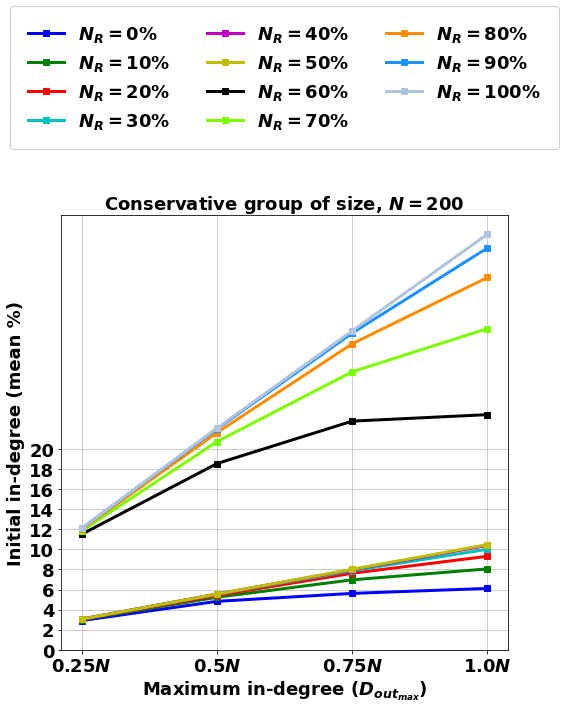

In [ ]:
import matplotlib.pyplot as plt
index = 0 # vary from 0 to 4
group = 0 # vary from 0 to 1
start_c = np.array([0,44,88,132,176])
start_l = np.array([220,264,308,352,396])
lables = np.array(["0","10","20","30","40","50","60","70","80","90","100"])
groups = np.array(["Conservative","Liberal"])
clrs = ['b','g','r','c','m','y','k','lawngreen','darkorange','dodgerblue','lightsteelblue']

start=start_c

factor = N[index]/100

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(np.arange(0,4,step=1),mean[3][start[index]:start[index]+4]/factor,'s-',linewidth=3,linestyle='-',color=clrs[0],label="$N_{R}=%s\%%$"%(lables[0],))
plt.plot(np.arange(0,4,step=1),mean[3][start[index]+4:start[index]+8]/factor,'s-',linewidth=3,linestyle='-',color=clrs[1],label="$N_{R}=%s\%%$"%(lables[1],))
plt.plot(np.arange(0,4,step=1),mean[3][start[index]+8:start[index]+12]/factor,'s-',linewidth=3,linestyle='-',color=clrs[2],label="$N_{R}=%s\%%$"%(lables[2],))
plt.plot(np.arange(0,4,step=1),mean[3][start[index]+12:start[index]+16]/factor,'s-',linewidth=3,linestyle='-',color=clrs[3],label="$N_{R}=%s\%%$"%(lables[3],))
plt.plot(np.arange(0,4,step=1),mean[3][start[index]+16:start[index]+20]/factor,'s-',linewidth=3,linestyle='-',color=clrs[4],label="$N_{R}=%s\%%$"%(lables[4],))
plt.plot(np.arange(0,4,step=1),mean[3][start[index]+20:start[index]+24]/factor,'s-',linewidth=3,linestyle='-',color=clrs[5],label="$N_{R}=%s\%%$"%(lables[5],))
plt.plot(np.arange(0,4,step=1),mean[3][start[index]+24:start[index]+28]/factor,'s-',linewidth=3,linestyle='-',color=clrs[6],label="$N_{R}=%s\%%$"%(lables[6],))
plt.plot(np.arange(0,4,step=1),mean[3][start[index]+28:start[index]+32]/factor,'s-',linewidth=3,linestyle='-',color=clrs[7],label="$N_{R}=%s\%%$"%(lables[7],))
plt.plot(np.arange(0,4,step=1),mean[3][start[index]+32:start[index]+36]/factor,'s-',linewidth=3,linestyle='-',color=clrs[8],label="$N_{R}=%s\%%$"%(lables[8],))
plt.plot(np.arange(0,4,step=1),mean[3][start[index]+36:start[index]+40]/factor,'s-',linewidth=3,linestyle='-',color=clrs[9],label="$N_{R}=%s\%%$"%(lables[9],))
plt.plot(np.arange(0,4,step=1),mean[3][start[index]+40:start[index]+44]/factor,'s-',linewidth=3,linestyle='-',color=clrs[10],label="$N_{R}=%s\%%$"%(lables[10],))

plt.rcParams['figure.facecolor'] = 'ivory'
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
ax.set_xticks(np.arange(0,4,step=1))
ax.set_xticklabels(["$0.25N$","$0.5N$","$0.75N$","$1.0N$"])
plt.xticks(fontsize=18,fontweight='bold')
plt.yticks(np.arange(0,22,step=2),fontsize=18,fontweight='bold')
plt.xlabel('Maximum in-degree ($D_{out_{max}}$)',fontsize=18,fontweight='bold')
plt.ylabel('Initial in-degree (mean %)',fontsize=18,fontweight='bold')
plt.title("{0} group of size, $N=%d$".format(groups[group])%(N[index],),fontsize=18,fontweight='bold')
leg = plt.legend(fontsize=18,loc="upper center",fancybox=True,  bbox_to_anchor=(0.5, 1.5), ncol=3,
           framealpha=1.0, shadow=False, borderpad=1)
ax.grid(b=True, which='major', color='silver', linestyle='-')

plt.savefig('{0}_IOD_{1}.pdf'.format(groups[group],N[index]),format='pdf', bbox_inches='tight',Transparent=True)

## Final Out-degree

In [ ]:
import matplotlib.pyplot as plt
index = 1 # vary from 0 to 4
group = 0 # vary from 0 to 1
start_c = np.array([0,44,88,132,176])
start_l = np.array([220,264,308,352,396])
lables = np.array(["0","10","20","30","40","50","60","70","80","90","100"])
groups = np.array(["Conservative","Liberal"])
clrs = ['b','g','r','c','m','y','k','lawngreen','darkorange','dodgerblue','lightsteelblue']

start=start_c

factor = N[index]/100

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(np.arange(0,4,step=1),mean[4][start[index]:start[index]+4]/factor,'s-',linewidth=3,linestyle='-',color=clrs[0],label="$N_{R}=%s\%%$"%(lables[0],))
plt.plot(np.arange(0,4,step=1),mean[4][start[index]+4:start[index]+8]/factor,'s-',linewidth=3,linestyle='-',color=clrs[1],label="$N_{R}=%s\%%$"%(lables[1],))
plt.plot(np.arange(0,4,step=1),mean[4][start[index]+8:start[index]+12]/factor,'s-',linewidth=3,linestyle='-',color=clrs[2],label="$N_{R}=%s\%%$"%(lables[2],))
plt.plot(np.arange(0,4,step=1),mean[4][start[index]+12:start[index]+16]/factor,'s-',linewidth=3,linestyle='-',color=clrs[3],label="$N_{R}=%s\%%$"%(lables[3],))
plt.plot(np.arange(0,4,step=1),mean[4][start[index]+16:start[index]+20]/factor,'s-',linewidth=3,linestyle='-',color=clrs[4],label="$N_{R}=%s\%%$"%(lables[4],))
plt.plot(np.arange(0,4,step=1),mean[4][start[index]+20:start[index]+24]/factor,'s-',linewidth=3,linestyle='-',color=clrs[5],label="$N_{R}=%s\%%$"%(lables[5],))
plt.plot(np.arange(0,4,step=1),mean[4][start[index]+24:start[index]+28]/factor,'s-',linewidth=3,linestyle='-',color=clrs[6],label="$N_{R}=%s\%%$"%(lables[6],))
plt.plot(np.arange(0,4,step=1),mean[4][start[index]+28:start[index]+32]/factor,'s-',linewidth=3,linestyle='-',color=clrs[7],label="$N_{R}=%s\%%$"%(lables[7],))
plt.plot(np.arange(0,4,step=1),mean[4][start[index]+32:start[index]+36]/factor,'s-',linewidth=3,linestyle='-',color=clrs[8],label="$N_{R}=%s\%%$"%(lables[8],))
plt.plot(np.arange(0,4,step=1),mean[4][start[index]+36:start[index]+40]/factor,'s-',linewidth=3,linestyle='-',color=clrs[9],label="$N_{R}=%s\%%$"%(lables[9],))
plt.plot(np.arange(0,4,step=1),mean[4][start[index]+40:start[index]+44]/factor,'s-',linewidth=3,linestyle='-',color=clrs[10],label="$N_{R}=%s\%%$"%(lables[10],))

plt.rcParams['figure.facecolor'] = 'ivory'
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
ax.set_xticks(np.arange(0,4,step=1))
ax.set_xticklabels(["$0.25N$","$0.5N$","$0.75N$","$1.0N$"])
plt.xticks(fontsize=18,fontweight='bold')
plt.yticks(np.arange(0,33,step=3),fontsize=18,fontweight='bold')
plt.xlabel('Maximum Out-degree ($D_{out_{max}}$)',fontsize=18,fontweight='bold')
plt.ylabel('Final out-degree (mean %)',fontsize=18,fontweight='bold')
plt.title("{0} group of size, $N=%d$".format(groups[group])%(N[index],),fontsize=18,fontweight='bold')
leg = plt.legend(fontsize=18,loc="upper center",fancybox=True,  bbox_to_anchor=(0.5, 1.5), ncol=3,
           framealpha=1.0, shadow=False, borderpad=1)
ax.grid(b=True, which='major', color='silver', linestyle='-')

plt.savefig('DNDH{0}_FOD_{1}.pdf'.format(groups[group],N[index]),format='pdf', bbox_inches='tight',Transparent=True)

## Groups

In [ ]:
import matplotlib.pyplot as plt
index = 0 # vary from 0 to 4
group = 1 # vary from 0 to 1
start_c = np.array([0,44,88,132,176])
start_l = np.array([220,264,308,352,396])
lables = np.array(["0","10","20","30","40","50","60","70","80","90","100"])
groups = np.array(["Conservative","Liberal"])
clrs = ['b','g','r','c','m','y','k','lawngreen','darkorange','dodgerblue','lightsteelblue']

start=start_l

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(np.arange(0,4,step=1),mean[0][start[index]:start[index]+4],'s-',linewidth=3,linestyle='-',color=clrs[0],label="$N_{R}=%s\%%$"%(lables[0],))
plt.plot(np.arange(0,4,step=1),mean[0][start[index]+4:start[index]+8],'s-',linewidth=3,linestyle='-',color=clrs[1],label="$N_{R}=%s\%%$"%(lables[1],))
plt.plot(np.arange(0,4,step=1),mean[0][start[index]+8:start[index]+12],'s-',linewidth=3,linestyle='-',color=clrs[2],label="$N_{R}=%s\%%$"%(lables[2],))
plt.plot(np.arange(0,4,step=1),mean[0][start[index]+12:start[index]+16],'s-',linewidth=3,linestyle='-',color=clrs[3],label="$N_{R}=%s\%%$"%(lables[3],))
plt.plot(np.arange(0,4,step=1),mean[0][start[index]+16:start[index]+20],'s-',linewidth=3,linestyle='-',color=clrs[4],label="$N_{R}=%s\%%$"%(lables[4],))
plt.plot(np.arange(0,4,step=1),mean[0][start[index]+20:start[index]+24],'s-',linewidth=3,linestyle='-',color=clrs[5],label="$N_{R}=%s\%%$"%(lables[5],))
plt.plot(np.arange(0,4,step=1),mean[0][start[index]+24:start[index]+28],'s-',linewidth=3,linestyle='-',color=clrs[6],label="$N_{R}=%s\%%$"%(lables[6],))
plt.plot(np.arange(0,4,step=1),mean[0][start[index]+28:start[index]+32],'s-',linewidth=3,linestyle='-',color=clrs[7],label="$N_{R}=%s\%%$"%(lables[7],))
plt.plot(np.arange(0,4,step=1),mean[0][start[index]+32:start[index]+36],'s-',linewidth=3,linestyle='-',color=clrs[8],label="$N_{R}=%s\%%$"%(lables[8],))
plt.plot(np.arange(0,4,step=1),mean[0][start[index]+36:start[index]+40],'s-',linewidth=3,linestyle='-',color=clrs[9],label="$N_{R}=%s\%%$"%(lables[9],))
plt.plot(np.arange(0,4,step=1),mean[0][start[index]+40:start[index]+44],'s-',linewidth=3,linestyle='-',color=clrs[10],label="$N_{R}=%s\%%$"%(lables[10],))

plt.rcParams['figure.facecolor'] = 'ivory'
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
ax.set_xticks(np.arange(0,4,step=1))
ax.set_xticklabels(["$0.25N$","$0.5N$","$0.75N$","$1.0N$"])
plt.xticks(fontsize=18,fontweight='bold')
plt.yticks(np.arange(0,4.5,step=0.5),fontsize=18,fontweight='bold')
plt.xlabel('Maximum Out-degree ($D_{out_{max}}$)',fontsize=18,fontweight='bold')
plt.ylabel('Number of factions',fontsize=18,fontweight='bold')
plt.title("{0} group of size, $N=%d$".format(groups[group])%(N[index],),fontsize=18,fontweight='bold')
leg = plt.legend(fontsize=18,loc="upper center",fancybox=True,  bbox_to_anchor=(0.5, 1.5), ncol=3,
           framealpha=1.0, shadow=False, borderpad=1)
ax.grid(b=True, which='major', color='silver', linestyle='-')

plt.savefig('DNDH{0}_Groups_{1}.pdf'.format(groups[group],N[index]),format='pdf', bbox_inches='tight',Transparent=True)

## Group Size

In [ ]:
import matplotlib.pyplot as plt
index = 0 # vary from 0 to 4
group = 0 # vary from 0 to 1
start_c = np.array([0,44,88,132,176])
start_l = np.array([220,264,308,352,396])
lables = np.array(["0","10","20","30","40","50","60","70","80","90","100"])
groups = np.array(["Conservative","Liberal"])
clrs = ['b','g','r','c','m','y','k','lawngreen','darkorange','dodgerblue','lightsteelblue']

start=start_c

factor = 1#N[index]/100

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(np.arange(0,4,step=1),mean[2][start[index]:start[index]+4]/factor,'s-',linewidth=3,linestyle='-',color=clrs[0],label="$N_{R}=%s\%%$"%(lables[0],))
plt.plot(np.arange(0,4,step=1),mean[2][start[index]+4:start[index]+8]/factor,'s-',linewidth=3,linestyle='-',color=clrs[1],label="$N_{R}=%s\%%$"%(lables[1],))
plt.plot(np.arange(0,4,step=1),mean[2][start[index]+8:start[index]+12]/factor,'s-',linewidth=3,linestyle='-',color=clrs[2],label="$N_{R}=%s\%%$"%(lables[2],))
plt.plot(np.arange(0,4,step=1),mean[2][start[index]+12:start[index]+16]/factor,'s-',linewidth=3,linestyle='-',color=clrs[3],label="$N_{R}=%s\%%$"%(lables[3],))
plt.plot(np.arange(0,4,step=1),mean[2][start[index]+16:start[index]+20]/factor,'s-',linewidth=3,linestyle='-',color=clrs[4],label="$N_{R}=%s\%%$"%(lables[4],))
plt.plot(np.arange(0,4,step=1),mean[2][start[index]+20:start[index]+24]/factor,'s-',linewidth=3,linestyle='-',color=clrs[5],label="$N_{R}=%s\%%$"%(lables[5],))
plt.plot(np.arange(0,4,step=1),mean[2][start[index]+24:start[index]+28]/factor,'s-',linewidth=3,linestyle='-',color=clrs[6],label="$N_{R}=%s\%%$"%(lables[6],))
plt.plot(np.arange(0,4,step=1),mean[2][start[index]+28:start[index]+32]/factor,'s-',linewidth=3,linestyle='-',color=clrs[7],label="$N_{R}=%s\%%$"%(lables[7],))
plt.plot(np.arange(0,4,step=1),mean[2][start[index]+32:start[index]+36]/factor,'s-',linewidth=3,linestyle='-',color=clrs[8],label="$N_{R}=%s\%%$"%(lables[8],))
plt.plot(np.arange(0,4,step=1),mean[2][start[index]+36:start[index]+40]/factor,'s-',linewidth=3,linestyle='-',color=clrs[9],label="$N_{R}=%s\%%$"%(lables[9],))
plt.plot(np.arange(0,4,step=1),mean[2][start[index]+40:start[index]+44]/factor,'s-',linewidth=3,linestyle='-',color=clrs[10],label="$N_{R}=%s\%%$"%(lables[10],))

plt.rcParams['figure.facecolor'] = 'ivory'
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
ax.set_xticks(np.arange(0,4,step=1))
ax.set_xticklabels(["$0.25N$","$0.5N$","$0.75N$","$1.0N$"])
plt.xticks(fontsize=18,fontweight='bold')
plt.yticks(np.arange(188,204,step=2),fontsize=18,fontweight='bold')
plt.xlabel('Maximum Out-degree ($D_{out_{max}}$)',fontsize=18,fontweight='bold')
plt.ylabel('Population of the largest opinion faction',fontsize=18,fontweight='bold')
plt.title("{0} group of size, $N=%d$".format(groups[group])%(N[index],),fontsize=18,fontweight='bold')
leg = plt.legend(fontsize=18,loc="upper center",fancybox=True,  bbox_to_anchor=(0.5, 1.5), ncol=3,
           framealpha=1.0, shadow=False, borderpad=1)
ax.grid(b=True, which='major', color='silver', linestyle='-')

plt.savefig('DNDH{0}_GSize_{1}.pdf'.format(groups[group],N[index]),format='pdf', bbox_inches='tight',Transparent=True)